In [1]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/ham10000 project/Ham10000imgs.zip'

Mounted at /content/drive


In [4]:
import shutil
import zipfile
import os

shutil.rmtree('/content/ham10000', ignore_errors=True)
os.makedirs('/content/ham10000', exist_ok=True)

In [7]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall('/content/ham10000')

print(os.listdir('/content/ham10000'))


['all_images', 'hmnist_8_8_RGB.csv', 'hmnist_28_28_RGB.csv', 'HAM10000_metadata.csv', 'hmnist_8_8_L.csv', 'hmnist_28_28_L.csv', 'HAM10000_images_part_2', 'ham10000_images_part_1', 'HAM10000_images_part_1', 'ham10000_images_part_2']


In [8]:
os.makedirs('/content/ham10000/all_images', exist_ok=True)

for fname in os.listdir('/content/ham10000/ham10000_images_part_1'):
  shutil.copy(f'/content/ham10000/ham10000_images_part_1/{fname}', '/content/ham10000/all_images')

for fname in os.listdir('/content/ham10000/ham10000_images_part_2'):
  shutil.copy(f'/content/ham10000/ham10000_images_part_2/{fname}', '/content/ham10000/all_images')

In [9]:
import pandas as pd

df = pd.read_csv('/content/ham10000/HAM10000_metadata.csv')
df['path'] = df['image_id'].apply(lambda x: f'/content/ham10000/all_images/{x}.jpg')

In [10]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['dx'])

In [12]:
from torchvision import datasets
import torchvision.transforms as transforms

training_transform = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.RandomHorizontalFlip(),
  transforms.RandomVerticalFlip(),
  transforms.RandomRotation(degrees=20),
  transforms.RandomResizedCrop(224,scale=(0.8, 1.0)),
  transforms.ColorJitter(brightness=0.1,contrast=0.1),
  transforms.ToTensor()
])

testing_transform = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.ToTensor()
])

In [13]:
from PIL import Image
from torch.utils.data import Dataset

class HAM10000Dataset(Dataset):
  def __init__(self, df, transform=None):
    self.df = df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    img_path = self.df.iloc[idx]['path']
    image = Image.open(img_path).convert('RGB')
    label = self.df.iloc[idx]['label']
    if self.transform:
      image = self.transform(image)
    return image, label

In [14]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, stratify=df['label'], test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, stratify=temp_df['label'], test_size=0.5, random_state=42)

train_dataset = HAM10000Dataset(train_df, transform=training_transform)
val_dataset = HAM10000Dataset(val_df, transform=testing_transform)
test_dataset = HAM10000Dataset(test_df, transform=testing_transform)

In [15]:
print("Class distribution:")
print(df['dx'].value_counts())

Class distribution:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


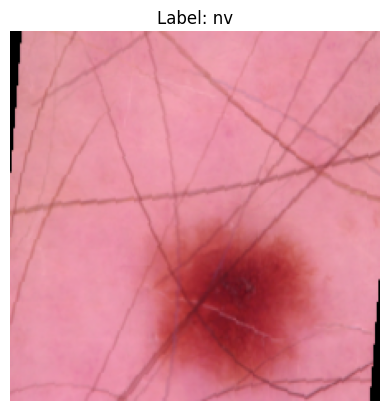

In [17]:
import matplotlib.pyplot as plt

sample_img, sample_label = train_dataset[0]

plt.imshow(sample_img.permute(1, 2, 0))
plt.title(f"Label: {label_encoder.inverse_transform([sample_label])[0]}")
plt.axis('off')
plt.show()